# Part 6.2 - Analysis for Train Set
---
### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
sns.axes_style("darkgrid")
%matplotlib inline

In [2]:
def filter_topics(df, topic_lsit):
    # remove data out of df if topic is not in topic_list
    return (df[df['topic'].isin(topic_list)].sort_values(by='topic', ascending=True))

In [3]:
def plot_topics(df, kind='', adjust_top=0.97, title='', height=3.5, col_wrap=2):
    if kind == 'scatter':
        g = sns.catplot(x="year", y='weight', hue="topic", col='keywords', col_wrap=col_wrap, 
                    kind='strip', height=height, aspect=2, jitter=1, dodge=False, s=5, legend=False,
                    data=df)
        g.fig.suptitle("Dominant Topics Distribution of {} Over Year".format(title), fontsize=16)
        
    elif kind == 'bar':
        g = sns.catplot(x="year", hue="topic", col='keywords', col_wrap=col_wrap, 
                    kind='count', height=height, aspect=2, dodge=False, legend=False, 
                    data=df)
        g.fig.suptitle("Dominant Topics Count of {} Over Year".format(title), fontsize=16)
        
    elif kind == 'point':
        g = sns.catplot(x="year", y='weight',  col='keywords', col_wrap=col_wrap, 
                    kind='point', height=height, aspect=2, dodge=False, s=1, legend=False, 
                    markers=',', scale=1,
                    data=df)
        g.fig.suptitle("Average Weight of {} Over Year".format(title), fontsize=16)
        
    else:
        print('wrong kind.')
        
    g.fig.subplots_adjust(top=adjust_top)
    g.set_xticklabels(rotation=90, step=2)
    return g

**For computing resource limitation, we did not train the full dataset, but trained a random sampling dataset (train set). In this part, we will use the topic modeling result from part 6.1 to analysis the train set.** 

**To evaluate and compare the distribution of topics, we use two metrics:**
1. The dominant topics count. 

    Every document has a dominant topic represent the most portion of its contents. By summing the number of dominant topics in a range of time, we see the variety and trend of the topic over time. It is easy to understand and fit for scatter plot, but it magnify the dominant topics weight in the document, and the count cannot reflect the weight in the time unit (year, month, etc.).

1. The average topic weights.

    This metric is the average weight of a topic through all documents in a range of time, it avoid the issue of distortion, but it also less significance which appear flat on plots.

**To visualize the topics, we use three plots:**
1. Scatter plot to dispaly the dominant tpics distribution over time.

1. Bar chart to display the dominant topics count over time.

1. Point chart the display the average topic weight over time.

**To mining the dataframes, we use two strategies:**
1. linear regression for coefficienct analysis.

1. polarity calculation for sentiment analysis.

## 1 Load dataframes

**Load the processed dataframes:**
* `topicKeys.txt`: topic words list
* `domTopic.csv`: document dominant topics dataframe
* `avgWeight.csv`: average topic weight dataframe

**Topics List:**

In [4]:
path = r'../models/train/topicKeys.txt'

df_topics = pd.read_table(path, 
                          header=None, 
                          index_col=None, 
                          names = ['topic_', 'weight_', 'keywords'],
                          encoding='utf8').sort_values(by='topic_').reset_index(drop=True)

topics_shape = df_topics.shape

In [5]:
print('Shape of dataframe:', topics_shape)
df_topics.head(5)

Shape of dataframe: (200, 3)


,topic_,weight_,keywords
0,0,0.00521,sale auction land property section lot sell sections acres public block instructions estate street auctioneers front...
1,1,0.00335,printing prizes cards prize horse tickets office drawing books divided forms programmes advertisements stamps column...
2,2,0.00631,seeds seed grass manure clover potatoes special manures oats turnip white red cocksfoot rape ton garden sacks stock ...
3,3,0.00710,company miss theatre opera night evening house performance audience stage play season part comedy success great ente...
4,4,0.01504,man life men people great work good world time young make things fact human mind women nature years knowledge social


**Docmument - dominant topics dataframe:**

In [6]:
path = r'../models/train/domTopics.csv'

df_domtopic = pd.read_csv(path, 
                          header=None, 
                          index_col=None, 
                          names = ['id', 'region', 'year', 'topic', 'weight', 'keywords'],
                          dtype={2:'str'},
                          encoding='utf8').sort_values(by='id').reset_index(drop=True)

In [7]:
print('Shape of dataframe:', df_domtopic.shape)
df_domtopic.head(5)

Shape of dataframe: (603629, 6)


,id,region,year,topic,weight,keywords
0,1854215,Auckland,1862,176,0.375211,advertisements office paper published column post times news notice new_zealand subscribers advertising insertion pu...
1,1854233,Auckland,1863,167,0.395599,business public orders street notice general begs stock attention premises made inform advertisements goods prices p...
2,1854245,Auckland,1863,76,0.276675,apply freight passage passengers new_zealand steam company wellington london agents tons shipping leave melbourne li...
3,1854253,Auckland,1863,14,0.280050,act person regulations made time persons section part exceeding land provisions law provided liable property payment...
4,1854264,Auckland,1863,188,0.263871,estate creditors public trustee bankruptcy day notice office trust bankrupt court accounts paid business debts act t...


**Average topic weight dataframe:**

In [8]:
path = r'../models/train/avgWeight.csv'

# generate new column names
columns = [str(x) for x in list(range(topics_shape[0]))]
columns.insert(0, 'year')

df_avgweight = pd.read_csv(path, 
                           header=None, 
                           index_col=None, 
                           names = columns,
                           dtype={0:'str'},
                           encoding='utf8')

# melt for plot
df_avgweight = pd.melt(df_avgweight,
                       id_vars='year',
                       value_vars=list(df_avgweight.columns[1:]),
                       var_name='topic',
                       value_name='weight')
# change data type
df_avgweight.topic = df_avgweight.topic.astype(int)

# join
df_avgweight = (df_avgweight
                .merge(df_topics, left_on='topic', right_on='topic_')
                .drop('topic_', axis=1)
                .drop('weight_', axis=1)
                .sort_values(by=['year', 'topic'])
                .reset_index(drop=True))

In [9]:
print('Shape of dataframe:', df_avgweight.shape)
df_avgweight.head(5)

Shape of dataframe: (20800, 4)


,year,topic,weight,keywords
0,1839,0,0.000018,sale auction land property section lot sell sections acres public block instructions estate street auctioneers front...
1,1839,1,0.000011,printing prizes cards prize horse tickets office drawing books divided forms programmes advertisements stamps column...
2,1839,2,0.000021,seeds seed grass manure clover potatoes special manures oats turnip white red cocksfoot rape ton garden sacks stock ...
3,1839,3,0.000024,company miss theatre opera night evening house performance audience stage play season part comedy success great ente...
4,1839,4,0.000051,man life men people great work good world time young make things fact human mind women nature years knowledge social


## 2 The Most Distinct Documents

**First of all, check the document with the highest weight topic through all documents, which means it is the most distict document in the corpus, easy to find the topic by eyes. Here we print the top 3 of them.**

In [ ]:
df_domtopic.sort_values(by='weight', ascending=False).head(3)

In [ ]:
id_list = []
for i in range(3):
    id_list.append(df_domtopic.sort_values(by='weight', ascending=False).iloc[i]['id'])

In [ ]:
%%bash -s $id_list[0]
grep -nw train.csv -e $1

In [ ]:
%%bash -s $id_list[1]
grep -nw train.csv -e $1

In [ ]:
%%bash -s $id_list[2]
grep -nw train.csv -e $1

## 3 General Distribution of Topics

**Then we plot the general distribution of dominant topics and average topic weight.**

In [ ]:
df_plt_dom = df_domtopic
df_plt_dom.keywords = df_plt_d.keywords.str.slice(0,65)+'...'

g = sns.catplot(x="year", y='weight',
            kind='strip', height=4, aspect=2, jitter=1, dodge=False, s=5, legend=False,
            data=df_plt_dom)

g.fig.suptitle("Dominant Topics Distribution in General Over Year", fontsize=16)
g.fig.subplots_adjust(top=adjust_top)
g.set_xticklabels(rotation=90)

In [ ]:
g = sns.catplot(x="year",
            kind='count', height=4, aspect=2, dodge=False, legend=False, 
            data=df_plt_dom)

g.fig.suptitle("Dominant Topics Count in General Over Year", fontsize=16)
g.fig.subplots_adjust(top=adjust_top)
g.set_xticklabels(rotation=90)

In [ ]:
df_plt_avg = df_avgweight
df_plt_avg.keywords = df_plt_avg.keywords.str.slice(0,65)+'...'

g = sns.catplot(x="year", y='weight',  col='topic', 
            kind='point', height=height, aspect=2, dodge=False, s=1, legend=False, 
            markers=',', scale=1,
            data=df_plt_avg)

g.fig.suptitle("Average Topic Weights in General Over Year", fontsize=16)
g.fig.subplots_adjust(top=adjust_top)
g.set_xticklabels(rotation=90)

## 4 The Most Frequent Topics

**The most frequent topics appeared the most in the corpus, it is not necessarily the most count of dominant topics, but the highest total weight of topics, shown as below:**

In [10]:
df_topics.sort_values(by='weight_', ascending=False).head(10)

,topic_,weight_,keywords
60,60,0.04135,association press received telegraph copyright london united electric cable july sydney april june march august aust...
45,45,0.03855,tie ths ill day tin time ton zealand end tht ail aid hat thai oil tiie land ter son column
149,149,0.02996,time good year made work great present fact week day make years place long past days number doubt ago position
152,152,0.01999,mrs miss messrs smith misses wilson brown williams jones taylor john james campbell anderson martin thompson scott c...
185,185,0.01933,sydney south melbourne australia australian wales received new_zealand victoria queensland adelaide government news ...
103,103,0.01892,letter sir editor public made paper time matter statement fact correspondent give make letters published times quest...
167,167,0.01825,business public orders street notice general begs stock attention premises made inform advertisements goods prices p...
100,100,0.01713,matter question thought made time opinion present asked position put make give case considered fact people regard su...
174,174,0.01653,man good don't time day make asked put young back boy thing it's told people give home things i'm men
10,10,0.01607,association meeting wellington conference auckland new_zealand union committee council decided held press resolution...


**Generate dominant topics dataframe for plot:**

In [57]:
topic_list = df_topics.sort_values(by='weight_', ascending=False).topic_[:10].tolist()

print('List of topics to plot:', topic_list)

df_plt_dom = filter_topics(df_domtopic, topic_list)

df_plt_dom.keywords = df_plt_d.keywords.str.slice(0,65)+'...'

df_plt_avg = filter_topics(df_plt_avg, topic_list)

df_plt_avg.keywords = df_plt_avg.keywords.str.slice(0,65)+'...'

print('Shape of dataframe:', df_plt_dom.shape)
print('Shape of dataframe:', df_plt_avg.shape)

Shape of dataframe: (53636, 6)


,id,region,year,topic,weight,keywords
252055,13688813,Taranaki,1903,185,0.353908,sydney south melbourne australia australian wales received n...
327114,17100802,Wellington,1918,185,0.524064,sydney south melbourne australia australian wales received n...
313881,16633991,Waikato,1920,10,0.366842,association meeting wellington conference auckland new_zeala...
44291,3627372,Manawatu-Wanganui,1893,167,0.605629,business public orders street notice general begs stock atte...
557427,28639154,Auckland,1901,149,0.374216,time good year made work great present fact week day make ye...


**Dominant topics distribution over year:**

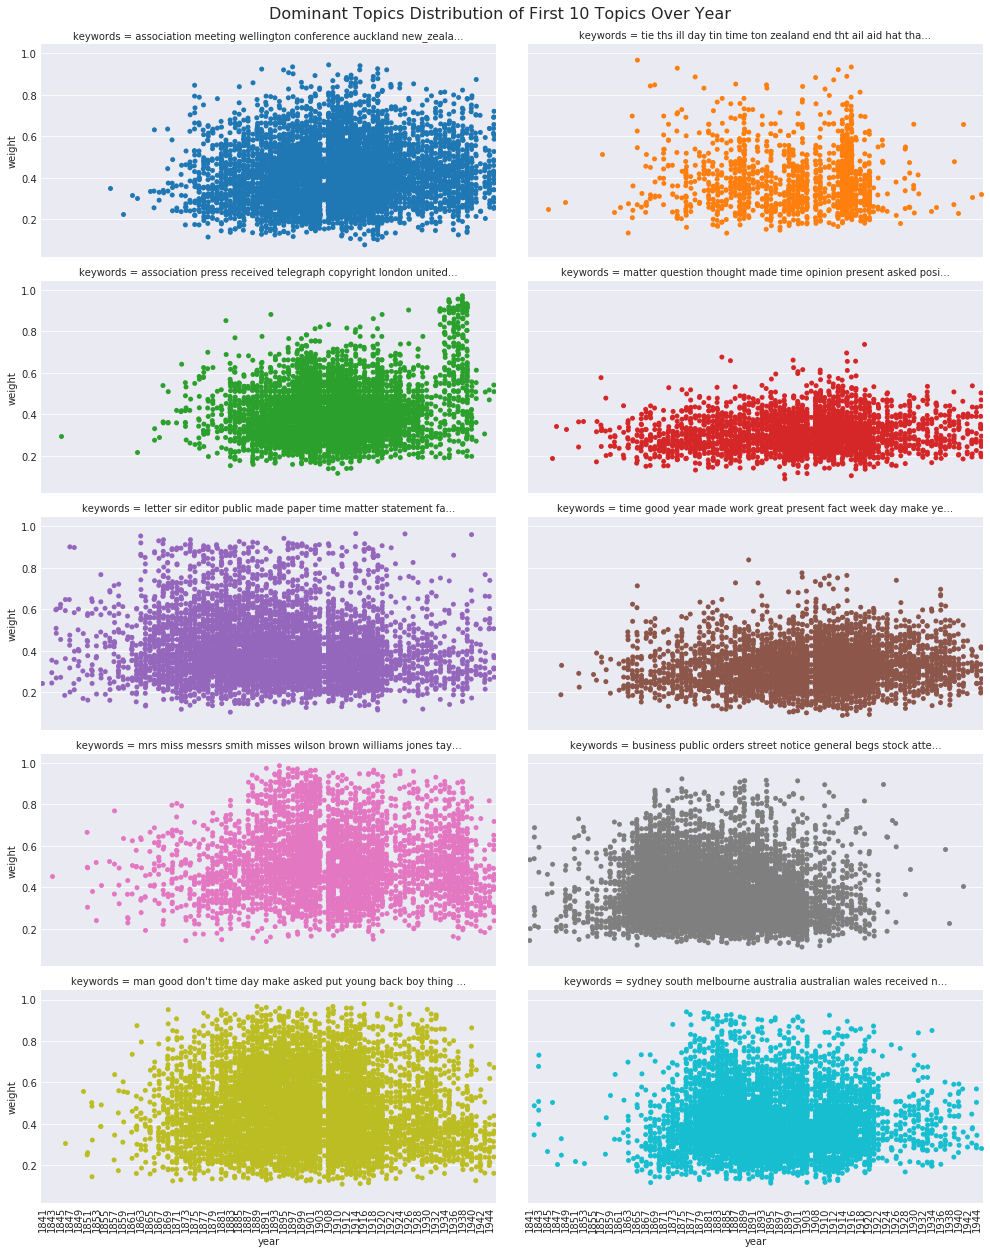

In [56]:
plot_topics(df_plt_dom, 
            'scatter', 
            adjust_top=0.95,
            title='First 10 Topics',
            height=3.5,
            col_wrap=2)

**Dominant topics count over year:**

In [ ]:
plot_topics(df_plt_dom, 
            'bar', 
            adjust_top=0.95,
            title='First 10 Topics',
            height=3.5,
            col_wrap=2)

**Average topic weight over year:**

In [ ]:
plot_topics(df_plt_avg, 
            'point', 
            adjust_top=0.95,
            title='First 10 Topics',
            height=3.5,
            col_wrap=2)

## 5 The Most Very Topics

**The most frequent topics are quantitively show the change of topics over time, but the trend of topics follows the general trend of all topics. By caculating the STD of each topics, we get the most very topics, then plot top 10 of them.**

In [ ]:
df_avgweight.groupby('topic')['weight'].std()